# Path Selection Model
### Logistic Regression, Random Forest, Extra Trees Classifier

This Notbook should predict whether a certain path in a model should be animated or not based on the embedding and additional features created.

For training we are using self-labeled data.

In [1]:
import os
os.chdir("..")

In [3]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pprint import pprint

### 1. Load and map data

Delete rows of logo_id (provided through filename) and order_id (not important).

In [4]:
#target = pd.read_csv("data/model_1/model_1_path_label.pkl")
with open('data/path_selector/path_selector_label.pkl', 'rb') as f:
    target = pickle.load(f)
target["logo"] = target["logo_id"].apply(lambda row: "logo_" + str(row)) # set up logo numeration for labeling
target = target.drop(['logo_id','order_id','filename'], axis = 1) # drop unnecessary attributes
target['animation_id'] = target['animation_id'].astype(int) #transform animation_id to int for mapping with feature table
target=target.rename(columns={"logo": "filename"}) # transform for feature mapping
target.head()

,animation_id,animate,filename
0,5,0.578947,logo_0
1,0,0.526316,logo_0
2,2,0.526316,logo_0
3,4,0.684211,logo_0
4,3,0.526316,logo_0


Load an match of training data

In [5]:
X_train = pd.read_csv("data/path_selector/path_selector_train.csv")
X_train.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
0,logo_0,1,13.535693,6.971131,-0.009867,-0.915823,-2.984741,5.383109,0.495111,-2.146576,...,0.0,0.0,0.0,0.0,0.0,0.400180,0.472019,0.700090,0.564323,10
1,logo_0,0,-1.000982,4.641413,1.455743,-0.487705,-1.037431,6.984421,-0.485484,-3.933893,...,0.0,0.0,0.0,0.0,0.0,0.500000,0.671553,0.250000,0.335776,10
2,logo_0,2,10.590673,0.533370,8.743198,0.241546,-2.132272,0.620374,1.687153,6.592582,...,0.0,0.0,0.0,0.0,0.0,0.787194,0.328324,0.499991,0.835838,10
3,logo_0,3,4.222565,-0.735711,5.308626,-0.090910,-4.875907,2.410124,0.314957,-1.771255,...,0.0,0.0,0.0,0.0,0.0,0.400206,0.472019,0.299897,0.564323,10
4,logo_0,4,1.776277,8.866785,-2.770646,-0.955766,-4.725605,5.412009,0.597616,2.331442,...,0.0,0.0,0.0,0.0,0.0,0.586900,0.315475,0.500106,0.170381,10


Merge dataframe based on the paths for which we have an annotation (df)

In [6]:
new_df = pd.merge(target, X_train,  how='left', left_on=['filename','animation_id'], right_on=['filename','animation_id'])
new_df.head(5)

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
0,5,0.578947,logo_0,6.032914,13.505794,1.009270,-2.116762,-5.308783,-0.882996,0.776551,...,0.0,0.0,0.0,0.0,0.0,0.500000,0.671547,0.750000,0.335779,10.0
1,0,0.526316,logo_0,-1.000982,4.641413,1.455743,-0.487705,-1.037431,6.984421,-0.485484,...,0.0,0.0,0.0,0.0,0.0,0.500000,0.671553,0.250000,0.335776,10.0
2,2,0.526316,logo_0,10.590673,0.533370,8.743198,0.241546,-2.132272,0.620374,1.687153,...,0.0,0.0,0.0,0.0,0.0,0.787194,0.328324,0.499991,0.835838,10.0
3,4,0.684211,logo_0,1.776277,8.866785,-2.770646,-0.955766,-4.725605,5.412009,0.597616,...,0.0,0.0,0.0,0.0,0.0,0.586900,0.315475,0.500106,0.170381,10.0
4,3,0.526316,logo_0,4.222565,-0.735711,5.308626,-0.090910,-4.875907,2.410124,0.314957,...,0.0,0.0,0.0,0.0,0.0,0.400206,0.472019,0.299897,0.564323,10.0


Delete rows in which we have NaN embeddings

In [7]:
new_df = new_df.dropna(axis=0,thresh=4)

In [8]:
print(f'Size of train data: {new_df.shape[0]}')
print(f'Paths with label=0 in train data: {new_df[new_df["animate"]<0.5].shape[0]}, paths with label=1 in train data: {new_df[new_df["animate"]>=0.5].shape[0]}')

Size of train data: 2750
Paths with label=0 in train data: 1923, paths with label=1 in train data: 827


Load Test data set and drop same features

In [9]:
X_test = pd.read_csv("data/path_selector/path_selector_test.csv")
X_test.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
0,logo_147,10,0.288970,-7.284798,1.094182,-4.437811,-0.352077,-0.933593,-0.200254,0.931484,...,141.538462,22.076923,134.923077,34.769231,121.230769,0.017877,0.111550,0.168001,0.084745,13
1,logo_147,0,-2.807291,-11.223132,3.151704,2.541029,-0.119346,0.909742,2.923519,-1.477561,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.077887,0.707306,0.038944,0.562185,13
2,logo_147,1,0.869143,-11.525720,-0.201577,3.906369,-2.661400,-0.757390,-0.195925,-0.380663,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.026691,0.467979,0.161487,0.450085,13
3,logo_147,12,9.519547,-1.598271,-4.577534,-2.522939,-0.754545,-0.054362,-1.478206,-1.002636,...,6.538462,22.076923,42.923077,34.769231,113.230769,0.057923,0.271332,0.502114,0.135666,13
4,logo_147,2,-0.253583,-11.400860,-0.170891,5.689338,-0.972701,1.972220,-0.119872,0.083583,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.050151,0.477448,0.113555,0.445340,13


In [10]:
test_df = pd.merge(target, X_test,  how='left', left_on=['filename','animation_id'], right_on=['filename','animation_id'])
test_df = test_df.dropna(axis=0, thresh=4)
test_df.head()

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
1150,11,1.0,logo_147,8.631416,-4.865439,-3.530718,7.273989,-0.570165,1.089548,-2.160627,...,6.538462,22.076923,42.923077,34.769231,113.230769,0.181234,0.799582,0.414369,0.600209,13.0
1151,3,0.0,logo_147,4.143114,-9.390166,-2.863680,9.640171,-2.305684,3.560657,0.598082,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.119033,0.477738,0.247479,0.445206,13.0
1152,5,0.0,logo_147,19.417316,7.030688,-7.839398,0.146505,0.820325,0.368229,2.514925,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.077890,0.707295,0.848451,0.562168,13.0
1153,4,0.0,logo_147,13.620035,-0.552860,-6.612630,0.734536,-0.983774,0.265629,2.682790,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.077891,0.707306,0.600244,0.562174,13.0
1154,0,0.0,logo_147,-2.807291,-11.223132,3.151704,2.541029,-0.119346,0.909742,2.923519,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.077887,0.707306,0.038944,0.562185,13.0


In [11]:
print(f'Size of test data: {test_df.shape[0]}')
print(f'Paths with label=0 in test data: {test_df[test_df["animate"]<0.5].shape[0]}, paths with label=1 in test data: {test_df[test_df["animate"]>=0.5].shape[0]}')

Size of test data: 691
Paths with label=0 in test data: 525, paths with label=1 in test data: 166


### 2. Feature Selection

We want to take a look on the correlation matrix to identify features which can be excluded upfront.

C:\Users\sarah\Anaconda3\envs\animate_logos\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


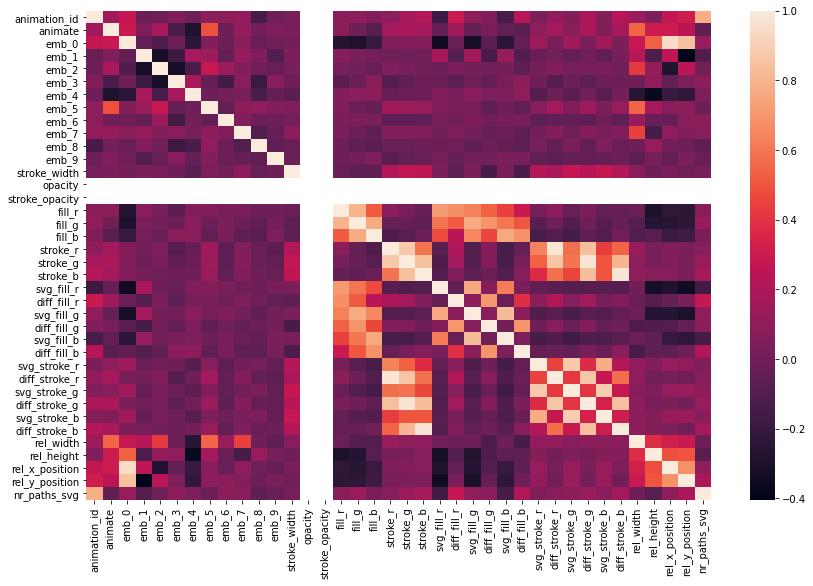

In [12]:
corrMatrix = new_df.corr()
f = plt.figure(figsize=(14, 9))
sn.heatmap(corrMatrix, annot=False)
f.show()

Since both _opacity_ and _stroke_opacity_ are always of value *one* we exclude them.

In [13]:
new_df = new_df.drop(['opacity','stroke_opacity'], axis=1, errors='ignore')
test_df = test_df.drop(['opacity','stroke_opacity'], axis= 1, errors='ignore')

Also exclude stroke attributes because they are mostly not given.

In [14]:
new_df = new_df.drop(['stroke_r','stroke_g', 'stroke_b', 'stroke_width'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_r', 'diff_stroke_r'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_g', 'diff_stroke_g'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_b', 'diff_stroke_b'], axis= 1, errors='ignore')

test_df = test_df.drop(['stroke_r','stroke_g', 'stroke_b', 'stroke_width'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_r', 'diff_stroke_r'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_g', 'diff_stroke_g'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_b', 'diff_stroke_b'], axis= 1, errors='ignore')

Check for features that have a to high correlation.

In [15]:
correlated_features = set()
correlation_matrix = new_df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
#corr_features = list(correlated_features)
#test_df = test_df.drop(corr_features, axis=1, errors='ignore')
#new_df = new_df.drop(corr_features, axis=1, errors='ignore')

The following features are correlated: svg_fill_b and svg_fill_g. Correlation = 0.82
The following features are correlated: rel_x_position and emb_0. Correlation = 0.95
The following features are correlated: rel_y_position and emb_0. Correlation = 0.85
Drop the following features: {'svg_fill_b', 'rel_x_position', 'rel_y_position'}


Animation ID is only an identifier and is excluded later. Only drop rel_x_position for logistic regression (is done later). Decision Trees are not affected by multicollinearity in features.

### 3. Preprocessing

Add function that replaces animate decision with binary integrer values

In [16]:
new_df['animate']=[0 if x < 0.5 else 1 for x in new_df['animate']]
test_df['animate']=[0 if x < 0.5 else 1 for x in test_df['animate']]

#### Perform split between features and target

In [17]:
x_train = new_df.drop(['filename','animation_id','animate'], axis=1, errors='ignore')
y_train = new_df['animate']
x_test = test_df.drop(['filename','animation_id','animate'], axis=1, errors='ignore')
y_test = test_df['animate']

### 4. Implement models

#### 4.1 Random Forest

#### Randomized search on hyperparameters

In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=300, num=5)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num=4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [50, 70, 90, 110, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [5, 10],
 'n_estimators': [200, 225, 250, 275, 300]}


In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=5, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=   1.2s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=   1.3s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=   1.2s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=   1.1s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=   1.2s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 70, 90, 110, None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [200, 225, 250, 275,
                                                         300]},
                   random_state=42, verbose=2)

In [19]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 70,
 'bootstrap': True}

In [20]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
y_pred = base_model.predict(x_test)
print(f'Accuracy of random forest classifier on test set without hyperparameter optimization: {base_model.score(x_test, y_test)}')

Accuracy of random forest classifier on test set without hyperparameter optimization: 0.9247467438494935


In [21]:
best_random = rf_random.best_estimator_
best_random.fit(x_train, y_train)
y_pred = best_random.predict(x_test)
print(f'Accuracy of random forest classifier on test set with hyperparameter optimization: {best_random.score(x_test, y_test)}')

Accuracy of random forest classifier on test set with hyperparameter optimization: 0.9261939218523878


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       525
           1       0.82      0.88      0.85       166

    accuracy                           0.93       691
   macro avg       0.89      0.91      0.90       691
weighted avg       0.93      0.93      0.93       691



#### 4.2 Extra Trees Classifier

In [23]:
et = ExtraTreesClassifier(random_state=17)
et.fit(x_train, y_train)

ExtraTreesClassifier(random_state=17)

In [24]:
# 0.94
y_pred = et.predict(x_test)
print('Accuracy of extra trees classifier on test set: {:.2f}'.format(et.score(x_test, y_test)))

Accuracy of extra trees classifier on test set: 0.94


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       525
           1       0.88      0.89      0.88       166

    accuracy                           0.94       691
   macro avg       0.92      0.93      0.92       691
weighted avg       0.94      0.94      0.94       691



Feature ranking:
1. feature 19: rel_width (10.3%)
2. feature 0: emb_0 (8.96%)
3. feature 21: rel_x_position (7.95%)
4. feature 5: emb_5 (7.69%)
5. feature 22: rel_y_position (6.42%)
6. feature 20: rel_height (5.33%)
7. feature 10: fill_r (4.05%)
8. feature 14: diff_fill_r (3.85%)
9. feature 1: emb_1 (3.56%)
10. feature 2: emb_2 (3.49%)
11. feature 4: emb_4 (3.42%)
12. feature 3: emb_3 (3.2%)
13. feature 23: nr_paths_svg (3.17%)
14. feature 15: svg_fill_g (3.13%)
15. feature 12: fill_b (3.06%)
16. feature 8: emb_8 (2.94%)
17. feature 16: diff_fill_g (2.91%)
18. feature 13: svg_fill_r (2.8%)
19. feature 7: emb_7 (2.62%)
20. feature 17: svg_fill_b (2.59%)
21. feature 18: diff_fill_b (2.58%)
22. feature 11: fill_g (2.52%)
23. feature 6: emb_6 (1.92%)
24. feature 9: emb_9 (1.52%)


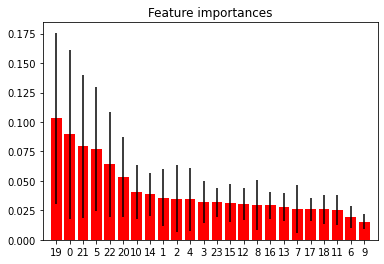

In [26]:
importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print(f"{f+1}. feature {indices[f]}: {x_train.columns[indices[f]]} ({round(importances[indices[f]]*100,2)}%)")

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

#### 4.3 XGBoost

In [27]:
# 0.91
xgb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print('Accuracy of XGBoost on test set: {:.2f}'.format(xgb.score(x_test, y_test)))

Accuracy of XGBoost on test set: 0.91


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       525
           1       0.75      0.91      0.82       166

    accuracy                           0.91       691
   macro avg       0.86      0.91      0.88       691
weighted avg       0.92      0.91      0.91       691



#### 4.4 Logistic Regression

Features which are correlated to strong are ignored

In [29]:
x_train_lr = x_train.drop(['rel_x_position'], axis=1, errors='ignore')
x_test_lr = x_test.drop(['rel_x_position'], axis= 1, errors='ignore')

Now we perform the actual regression

In [30]:
logreg = LogisticRegression(solver='lbfgs', max_iter=200000)
logreg.fit(x_train_lr, y_train)

LogisticRegression(max_iter=200000)

In [31]:
# 0.86
y_pred = logreg.predict(x_test_lr)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test_lr, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       525
           1       0.70      0.76      0.73       166

    accuracy                           0.86       691
   macro avg       0.81      0.83      0.82       691
weighted avg       0.87      0.86      0.86       691



### 5. Result

Extra Trees Classifier performed best.

In [33]:
# save model
filename = 'models/path_selector_extra_trees_classifier.sav'
pickle.dump(et, open(filename, 'wb'))

In [34]:
# load model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.9435600578871202
